# Imports

In [1]:
from sklearn.utils import shuffle
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import joblib
import pandas as pd
import os
import sagemaker
import re

In [2]:
from data import s3_folders

unbalanced = s3_folders.unbalanced
underSample = s3_folders.underSample
overSample = s3_folders.overSample
combined = s3_folders.combined

# Model Training 

The model will be defined and trained using the data uploaded to S3.

In [3]:
import sagemaker
from sagemaker import get_execution_role

# Our current execution role is required when creating the model as the training
# and inference code will need to access the model artifacts.
role = get_execution_role()

session = sagemaker.Session() # Store the current SageMaker session

In [4]:
# We need to retrieve the location of the container which is provided by Amazon for using XGBoost.
# As a matter of convenience, the training and inference code both use the same container.
from sagemaker.image_uris import retrieve

container = retrieve(framework = 'xgboost',region = session.boto_region_name, version = "1")

## 1. Unbalanced. 

We set the version variable for it will help us with file management.

In [5]:
version = "unbalanced"

Here we load the location of the files on S3 that were uploaded for this model. 

In [6]:
test_location = unbalanced["test"] #the information is loaded from the .py file created in the data preparation step
val_location = unbalanced["val"]
train_location = unbalanced["train"]

In [7]:
# S3 prefix (which folder will we use)
prefix = f'twitter_sentiment_{version}'

### Set the model

In [8]:
# First we create a SageMaker estimator object for our model.
xgb_unbalanced = sagemaker.estimator.Estimator(container, # The location of the container we wish to use
                                    role,                                    # What is our current IAM Role
                                    instance_count=1,                  # How many compute instances
                                    instance_type='ml.m4.xlarge',      # What kind of compute instances
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                    sagemaker_session=session)

# And then set the algorithm specific parameters.
xgb_unbalanced.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        early_stopping_rounds=10,
                        num_round=500)

### Fit the model

Set the training and validation data set on s3 to be used by sagemaker. This variables will let the model know where to find the information in S3 that will be used to estimate the model

In [9]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data=val_location, content_type='csv')

In [10]:
xgb_unbalanced.fit({'train': s3_input_train, 'validation': s3_input_validation})

2022-04-15 12:15:22 Starting - Starting the training job...
2022-04-15 12:15:49 Starting - Preparing the instances for trainingProfilerReport-1650024921: InProgress
............
2022-04-15 12:17:46 Downloading - Downloading input data...
2022-04-15 12:18:07 Training - Downloading the training image......
2022-04-15 12:19:07 Training - Training image download completed. Training in progress.Arguments: train
[2022-04-15:12:19:11:INFO] Running standalone xgboost training.
[2022-04-15:12:19:11:INFO] File size need to be processed in the node: 243.89mb. Available memory size in the node: 8484.62mb
[2022-04-15:12:19:11:INFO] Determined delimiter of CSV input is ','
[12:19:11] S3DistributionType set as FullyReplicated
[12:19:14] 20456x5000 matrix with 102280000 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2022-04-15:12:19:14:INFO] Determined delimiter of CSV input is ','
[12:19:14] S3DistributionType set as FullyReplicated
[12:19:15] 5113x5000 matrix wit

### Test the model

For this part of the process a transformer object will be created. This is an object can be understood as a function that used the artifacts (betas) created by the model and then uses them to predict based in a new data set. 
The test dataset will be given to the transformer and the results will be compared to the actual labels that were reserved for the test. 

In [12]:
#Create a transformer object. This will use the artifacts created by the estimator to transform (create a prediction) using the testing dataset.
xgb_unbalanced_transformer = xgb_unbalanced.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

In [13]:
xgb_unbalanced_transformer.transform(test_location, content_type='text/csv', split_type='Line') 
#the location of the test set is passed to the transfomer to perform the transformation. (predict)

.....................................Arguments: serve
Arguments: serve
[2022-04-15 12:30:31 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2022-04-15 12:30:31 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2022-04-15 12:30:31 +0000] [1] [INFO] Using worker: gevent
[2022-04-15 12:30:31 +0000] [21] [INFO] Booting worker with pid: 21
[2022-04-15 12:30:31 +0000] [22] [INFO] Booting worker with pid: 22
/opt/amazon/lib/python3.7/site-packages/gunicorn/workers/ggevent.py:65: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.util (/opt/amazon/lib/python3.7/site-packages/urllib3/util/__init__.py)', 'urllib3.util.ssl_ (/opt/amazon/lib/python3.7/site-packages/urllib3/util/ssl_.py)']. 
  monkey.patch_all(subpr

In [14]:
xgb_unbalanced_transformer.wait() #we wait until the transformer is done

Arguments: serve
Arguments: serve
[2022-04-15 12:30:31 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2022-04-15 12:30:31 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2022-04-15 12:30:31 +0000] [1] [INFO] Using worker: gevent
[2022-04-15 12:30:31 +0000] [21] [INFO] Booting worker with pid: 21
[2022-04-15 12:30:31 +0000] [22] [INFO] Booting worker with pid: 22
/opt/amazon/lib/python3.7/site-packages/gunicorn/workers/ggevent.py:65: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.util (/opt/amazon/lib/python3.7/site-packages/urllib3/util/__init__.py)', 'urllib3.util.ssl_ (/opt/amazon/lib/python3.7/site-packages/urllib3/util/ssl_.py)']. 
  monkey.patch_all(subprocess=True)
[2022-04-15:12:30:31:INFO

After the tranformation is done, we will specify a new folder where the results (the are created in a S3 folder) can be downloaded from S3.

In [15]:
data_dir = f"results_{version}"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

Next, using the next command we download the predictions made by the transformer object into the local folder.

In [16]:
!aws s3 cp --recursive $xgb_unbalanced_transformer.output_path $data_dir

download: s3://sagemaker-us-east-1-730413480526/xgboost-2022-04-15-12-24-34-046/test.csv.out to results_unbalanced/test.csv.out


Now the predictions are read with pandas into a dataframe.

In [17]:
predictions = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None) #the header is none because the first line is a prediction and not the name of the column
predictions = [round(num) for num in predictions.squeeze().values] #we convert the predictions to a list so it will be easier to compare with metrics with the real label.

Then we read the labels that were reserved in the data preparation in a local folder for the test.

In [18]:
test_y = pd.read_csv(f"data_prepared_{version}/test_y.csv",header = None) 
test_y = list(test_y[0]) #we transform the first column (not index) to a list so it will be compared with the predictions.

Now the results are compared by creating a confusion matrix out of the predictions vs the real labels. 
From the confusion matrix we can calculate the metric for classfication models. We use the tools in the sklearn module.

In [19]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_y, predictions, labels=None, sample_weight=None, normalize=None)
cm

array([[5940,   15],
       [ 354,   84]])

[Text(0, 0.5, 'Normal'), Text(0, 1.5, 'Violent')]

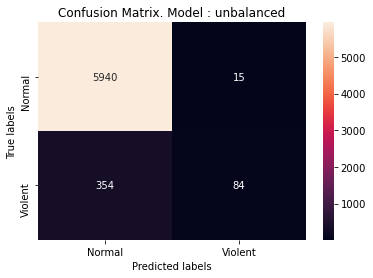

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title(f'Confusion Matrix. Model : {version}')
ax.xaxis.set_ticklabels(['Normal', 'Violent'])
ax.yaxis.set_ticklabels(['Normal', 'Violent'])

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print(f"Model version: {version}")
print("Accuracy: ", accuracy_score(test_y, predictions))
print("Precision: ", precision_score(test_y, predictions))
print("Recall: ", recall_score(test_y, predictions))

Model version: unbalanced
Accuracy:  0.9422806194274989
Precision:  0.8484848484848485
Recall:  0.1917808219178082


## 2. UnderSampled

We set the version variable for it will help us with file management.

In [23]:
version = "underSample"

Here we load the location of the files on S3 that were uploaded for this model. 

In [24]:
test_location = underSample["test"] #the information is loaded from the .py file created in the data preparation step
val_location = underSample["val"]
train_location = underSample["train"]

In [25]:
# S3 prefix (which folder will we use)
prefix = f'twitter_sentiment_{version}'

### Set the model

In [26]:
# First we create a SageMaker estimator object for our model.
xgb_underSample = sagemaker.estimator.Estimator(container, # The location of the container we wish to use
                                    role,                                    # What is our current IAM Role
                                    instance_count=1,                  # How many compute instances
                                    instance_type='ml.m4.xlarge',      # What kind of compute instances
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                    sagemaker_session=session)

# And then set the algorithm specific parameters.
xgb_underSample.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        early_stopping_rounds=10,
                        num_round=500)

### Fit the model

Set the training and validation data set on s3 to be used by sagemaker. This variables will let the model know where to find the information in S3 that will be used to estimate the model

In [27]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data=val_location, content_type='csv')

In [28]:
xgb_underSample.fit({'train': s3_input_train, 'validation': s3_input_validation})

2022-04-15 12:35:07 Starting - Starting the training job...ProfilerReport-1650026106: InProgress
...
2022-04-15 12:35:54 Starting - Preparing the instances for training.........
2022-04-15 12:37:30 Downloading - Downloading input data...
2022-04-15 12:38:06 Training - Downloading the training image......
2022-04-15 12:39:07 Training - Training image download completed. Training in progress..Arguments: train
[2022-04-15:12:39:11:INFO] Running standalone xgboost training.
[2022-04-15:12:39:11:INFO] File size need to be processed in the node: 34.42mb. Available memory size in the node: 8494.02mb
[2022-04-15:12:39:11:INFO] Determined delimiter of CSV input is ','
[12:39:11] S3DistributionType set as FullyReplicated
[12:39:11] 2887x5000 matrix with 14435000 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2022-04-15:12:39:11:INFO] Determined delimiter of CSV input is ','
[12:39:11] S3DistributionType set as FullyReplicated
[12:39:11] 721x5000 matrix with 3

### Test the model

For this part of the process a transformer object will be created. This is an object can be understood as a function that used the artifacts (betas) created by the model and then uses them to predict based in a new data set. 
The test dataset will be given to the transformer and the results will be compared to the actual labels that were reserved for the test. 

In [29]:
#Create a transformer object. This will use the artifacts created by the estimator to transform (create a prediction) using the testing dataset.
xgb_underSample_transformer = xgb_underSample.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

In [30]:
xgb_underSample_transformer.transform(test_location, content_type='text/csv', split_type='Line') 
#the location of the test set is passed to the transfomer to perform the transformation. (predict)

.....................................Arguments: serve
[2022-04-15 12:46:17 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2022-04-15 12:46:17 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2022-04-15 12:46:17 +0000] [1] [INFO] Using worker: gevent
[2022-04-15 12:46:17 +0000] [22] [INFO] Booting worker with pid: 22
Arguments: serve
[2022-04-15 12:46:17 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2022-04-15 12:46:17 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2022-04-15 12:46:17 +0000] [1] [INFO] Using worker: gevent
[2022-04-15 12:46:17 +0000] [22] [INFO] Booting worker with pid: 22
[2022-04-15 12:46:17 +0000] [23] [INFO] Booting worker with pid: 23
[2022-04-15 12:46:17 +0000] [24] [INFO] Booting worker with pid: 24
[2022-04-15 12:46:17 +0000] [25] [INFO] Booting worker with pid: 25
/opt/amazon/lib/python3.7/site-packages/gunicorn/workers/ggevent.py:65: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including Recursion

In [31]:
xgb_underSample_transformer.wait() #we wait until the transformer is done

Arguments: serve
[2022-04-15 12:46:17 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2022-04-15 12:46:17 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2022-04-15 12:46:17 +0000] [1] [INFO] Using worker: gevent
[2022-04-15 12:46:17 +0000] [22] [INFO] Booting worker with pid: 22
Arguments: serve
[2022-04-15 12:46:17 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2022-04-15 12:46:17 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2022-04-15 12:46:17 +0000] [1] [INFO] Using worker: gevent
[2022-04-15 12:46:17 +0000] [22] [INFO] Booting worker with pid: 22
[2022-04-15 12:46:17 +0000] [23] [INFO] Booting worker with pid: 23
[2022-04-15 12:46:17 +0000] [24] [INFO] Booting worker with pid: 24
[2022-04-15 12:46:17 +0000] [25] [INFO] Booting worker with pid: 25
/opt/amazon/lib/python3.7/site-packages/gunicorn/workers/ggevent.py:65: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also sile

After the tranformation is done, we will specify a new folder where the results (the are created in a S3 folder) can be downloaded from S3.

In [39]:
data_dir = f"results_{version}"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

Next, using the next command we download the predictions made by the transformer object into the local folder.

In [33]:
!aws s3 cp --recursive $xgb_underSample_transformer.output_path $data_dir

download: s3://sagemaker-us-east-1-730413480526/xgboost-2022-04-15-12-40-20-796/test.csv.out to results_underSample/test.csv.out


Now the predictions are read with pandas into a dataframe.

In [34]:
predictions = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None) #the header is none because the first line is a prediction and not the name of the column
predictions = [round(num) for num in predictions.squeeze().values] #we convert the predictions to a list so it will be easier to compare with metrics with the real label.

Then we read the labels that were reserved in the data preparation in a local folder for the test.

In [35]:
test_y = pd.read_csv(f"data_prepared_{version}/test_y.csv",header = None) 
test_y = list(test_y[0]) #we transform the first column (not index) to a list so it will be compared with the predictions.

Now the results are compared by creating a confusion matrix out of the predictions vs the real labels. 
From the confusion matrix we can calculate the metric for classfication models. We use the tools in the sklearn module.

In [36]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_y, predictions, labels=None, sample_weight=None, normalize=None)
cm

array([[5475,  480],
       [ 210,  228]])

[Text(0, 0.5, 'Normal'), Text(0, 1.5, 'Violent')]

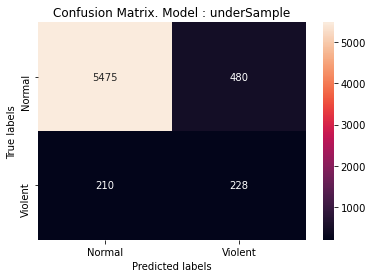

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title(f'Confusion Matrix. Model : {version}')
ax.xaxis.set_ticklabels(['Normal', 'Violent'])
ax.yaxis.set_ticklabels(['Normal', 'Violent'])

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print(f"Model version: {version}")
print("Accuracy: ", accuracy_score(test_y, predictions))
print("Precision: ", precision_score(test_y, predictions))
print("Recall: ", recall_score(test_y, predictions))

Model version: underSample
Accuracy:  0.8920694509619896
Precision:  0.3220338983050847
Recall:  0.5205479452054794


## 3. OverSampled

We set the version variable for it will help us with file management.

In [40]:
version = "overSample"

Here we load the location of the files on S3 that were uploaded for this model. 

In [41]:
test_location = overSample["test"] #the information is loaded from the .py file created in the data preparation step
val_location = overSample["val"]
train_location = overSample["train"]

In [42]:
# S3 prefix (which folder will we use)
prefix = f'twitter_sentiment_{version}'

### Set the model

In [43]:
# First we create a SageMaker estimator object for our model.
xgb_overSample = sagemaker.estimator.Estimator(container, # The location of the container we wish to use
                                    role,                                    # What is our current IAM Role
                                    instance_count=1,                  # How many compute instances
                                    instance_type='ml.m4.xlarge',      # What kind of compute instances
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                    sagemaker_session=session)

# And then set the algorithm specific parameters.
xgb_overSample.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        early_stopping_rounds=10,
                        num_round=500)

### Fit the model

Set the training and validation data set on s3 to be used by sagemaker. This variables will let the model know where to find the information in S3 that will be used to estimate the model

In [44]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data=val_location, content_type='csv')

In [45]:
xgb_overSample.fit({'train': s3_input_train, 'validation': s3_input_validation})

2022-04-15 12:48:51 Starting - Starting the training job...
2022-04-15 12:49:18 Starting - Preparing the instances for trainingProfilerReport-1650026930: InProgress
............
2022-04-15 12:51:15 Downloading - Downloading input data......
2022-04-15 12:52:15 Training - Downloading the training image...
2022-04-15 12:52:47 Training - Training image download completed. Training in progress..Arguments: train
[2022-04-15:12:52:51:INFO] Running standalone xgboost training.
[2022-04-15:12:52:51:INFO] File size need to be processed in the node: 453.37mb. Available memory size in the node: 8453.26mb
[2022-04-15:12:52:51:INFO] Determined delimiter of CSV input is ','
[12:52:51] S3DistributionType set as FullyReplicated
[12:52:57] 38024x5000 matrix with 190120000 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2022-04-15:12:52:57:INFO] Determined delimiter of CSV input is ','
[12:52:57] S3DistributionType set as FullyReplicated
[12:52:58] 9506x5000 matrix wi

### Test the model

For this part of the process a transformer object will be created. This is an object can be understood as a function that used the artifacts (betas) created by the model and then uses them to predict based in a new data set. 
The test dataset will be given to the transformer and the results will be compared to the actual labels that were reserved for the test. 

In [46]:
#Create a transformer object. This will use the artifacts created by the estimator to transform (create a prediction) using the testing dataset.
xgb_overSample_transformer = xgb_overSample.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

In [47]:
xgb_overSample_transformer.transform(test_location, content_type='text/csv', split_type='Line') 
#the location of the test set is passed to the transfomer to perform the transformation. (predict)

....................................Arguments: serve
[2022-04-15 13:26:02 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2022-04-15 13:26:02 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2022-04-15 13:26:02 +0000] [1] [INFO] Using worker: gevent
[2022-04-15 13:26:02 +0000] [21] [INFO] Booting worker with pid: 21
[2022-04-15 13:26:02 +0000] [22] [INFO] Booting worker with pid: 22
Arguments: serve
[2022-04-15 13:26:02 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2022-04-15 13:26:02 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2022-04-15 13:26:02 +0000] [1] [INFO] Using worker: gevent
[2022-04-15 13:26:02 +0000] [21] [INFO] Booting worker with pid: 21
[2022-04-15 13:26:02 +0000] [22] [INFO] Booting worker with pid: 22
/opt/amazon/lib/python3.7/site-packages/gunicorn/workers/ggevent.py:65: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour

In [48]:
xgb_overSample_transformer.wait() #we wait until the transformer is done

Arguments: serve
[2022-04-15 13:26:02 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2022-04-15 13:26:02 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2022-04-15 13:26:02 +0000] [1] [INFO] Using worker: gevent
[2022-04-15 13:26:02 +0000] [21] [INFO] Booting worker with pid: 21
[2022-04-15 13:26:02 +0000] [22] [INFO] Booting worker with pid: 22
Arguments: serve
[2022-04-15 13:26:02 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2022-04-15 13:26:02 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2022-04-15 13:26:02 +0000] [1] [INFO] Using worker: gevent
[2022-04-15 13:26:02 +0000] [21] [INFO] Booting worker with pid: 21
[2022-04-15 13:26:02 +0000] [22] [INFO] Booting worker with pid: 22
/opt/amazon/lib/python3.7/site-packages/gunicorn/workers/ggevent.py:65: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch 

After the tranformation is done, we will specify a new folder where the results (the are created in a S3 folder) can be downloaded from S3.

In [49]:
data_dir = f"results_{version}"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

Next, using the next command we download the predictions made by the transformer object into the local folder.

In [50]:
!aws s3 cp --recursive $xgb_overSample_transformer.output_path $data_dir

download: s3://sagemaker-us-east-1-730413480526/xgboost-2022-04-15-13-20-15-353/test.csv.out to results_overSample/test.csv.out


Now the predictions are read with pandas into a dataframe.

In [51]:
predictions = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None) #the header is none because the first line is a prediction and not the name of the column
predictions = [round(num) for num in predictions.squeeze().values] #we convert the predictions to a list so it will be easier to compare with metrics with the real label.

Then we read the labels that were reserved in the data preparation in a local folder for the test.

In [52]:
test_y = pd.read_csv(f"data_prepared_{version}/test_y.csv",header = None) 
test_y = list(test_y[0]) #we transform the first column (not index) to a list so it will be compared with the predictions.

Now the results are compared by creating a confusion matrix out of the predictions vs the real labels. 
From the confusion matrix we can calculate the metric for classfication models. We use the tools in the sklearn module.

In [53]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_y, predictions, labels=None, sample_weight=None, normalize=None)
cm

array([[5154,  801],
       [  75,  363]])

[Text(0, 0.5, 'Normal'), Text(0, 1.5, 'Violent')]

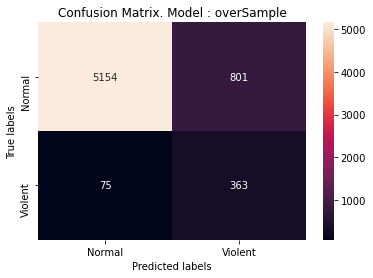

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title(f'Confusion Matrix. Model : {version}')
ax.xaxis.set_ticklabels(['Normal', 'Violent'])
ax.yaxis.set_ticklabels(['Normal', 'Violent'])

In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print(f"Model version: {version}")
print("Accuracy: ", accuracy_score(test_y, predictions))
print("Precision: ", precision_score(test_y, predictions))
print("Recall: ", recall_score(test_y, predictions))

Model version: overSample
Accuracy:  0.8629751290473956
Precision:  0.3118556701030928
Recall:  0.8287671232876712


## 4. Combined

We set the version variable for it will help us with file management.

In [56]:
version = "combined"

Here we load the location of the files on S3 that were uploaded for this model. 

In [57]:
test_location = combined["test"] #the information is loaded from the .py file created in the data preparation step
val_location = combined["val"]
train_location = combined["train"]

In [58]:
# S3 prefix (which folder will we use)
prefix = f'twitter_sentiment_{version}'

### Set the model

In [59]:
# First we create a SageMaker estimator object for our model.
xgb_combined = sagemaker.estimator.Estimator(container, # The location of the container we wish to use
                                    role,                                    # What is our current IAM Role
                                    instance_count=1,                  # How many compute instances
                                    instance_type='ml.m4.xlarge',      # What kind of compute instances
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                    sagemaker_session=session)

# And then set the algorithm specific parameters.
xgb_combined.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        early_stopping_rounds=10,
                        num_round=500)

### Fit the model

Set the training and validation data set on s3 to be used by sagemaker. This variables will let the model know where to find the information in S3 that will be used to estimate the model

In [60]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data=val_location, content_type='csv')

In [61]:
xgb_combined.fit({'train': s3_input_train, 'validation': s3_input_validation})

2022-04-15 13:27:03 Starting - Starting the training job...ProfilerReport-1650029223: InProgress
...
2022-04-15 13:27:52 Starting - Preparing the instances for training.........
2022-04-15 13:29:26 Downloading - Downloading input data......
2022-04-15 13:30:27 Training - Downloading the training image...
2022-04-15 13:30:54 Training - Training image download completed. Training in progress..Arguments: train
[2022-04-15:13:30:58:INFO] Running standalone xgboost training.
[2022-04-15:13:30:58:INFO] File size need to be processed in the node: 243.88mb. Available memory size in the node: 8486.12mb
[2022-04-15:13:30:58:INFO] Determined delimiter of CSV input is ','
[13:30:58] S3DistributionType set as FullyReplicated
[13:31:00] 20455x5000 matrix with 102275000 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2022-04-15:13:31:00:INFO] Determined delimiter of CSV input is ','
[13:31:00] S3DistributionType set as FullyReplicated
[13:31:01] 5113x5000 matrix wi

### Test the model

For this part of the process a transformer object will be created. This is an object can be understood as a function that used the artifacts (betas) created by the model and then uses them to predict based in a new data set. 
The test dataset will be given to the transformer and the results will be compared to the actual labels that were reserved for the test. 

In [62]:
#Create a transformer object. This will use the artifacts created by the estimator to transform (create a prediction) using the testing dataset.
xgb_combined_transformer = xgb_combined.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

In [63]:
xgb_combined_transformer.transform(test_location, content_type='text/csv', split_type='Line') 
#the location of the test set is passed to the transfomer to perform the transformation. (predict)

......................................Arguments: serve
Arguments: serve
[2022-04-15 13:52:51 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2022-04-15 13:52:51 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2022-04-15 13:52:51 +0000] [1] [INFO] Using worker: gevent
[2022-04-15 13:52:51 +0000] [21] [INFO] Booting worker with pid: 21
[2022-04-15 13:52:51 +0000] [22] [INFO] Booting worker with pid: 22
[2022-04-15 13:52:51 +0000] [23] [INFO] Booting worker with pid: 23
[2022-04-15 13:52:51 +0000] [24] [INFO] Booting worker with pid: 24
/opt/amazon/lib/python3.7/site-packages/gunicorn/workers/ggevent.py:65: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.util.ssl_ (/opt/amazon/lib/python3.7/site-packa

In [64]:
xgb_combined_transformer.wait() #we wait until the transformer is done

Arguments: serve
Arguments: serve
[2022-04-15 13:52:51 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2022-04-15 13:52:51 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2022-04-15 13:52:51 +0000] [1] [INFO] Using worker: gevent
[2022-04-15 13:52:51 +0000] [21] [INFO] Booting worker with pid: 21
[2022-04-15 13:52:51 +0000] [22] [INFO] Booting worker with pid: 22
[2022-04-15 13:52:51 +0000] [23] [INFO] Booting worker with pid: 23
[2022-04-15 13:52:51 +0000] [24] [INFO] Booting worker with pid: 24
/opt/amazon/lib/python3.7/site-packages/gunicorn/workers/ggevent.py:65: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.util.ssl_ (/opt/amazon/lib/python3.7/site-packages/urllib3/util/ssl_.py)', 'urllib3.u

After the tranformation is done, we will specify a new folder where the results (the are created in a S3 folder) can be downloaded from S3.

In [65]:
data_dir = f"results_{version}"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

Next, using the next command we download the predictions made by the transformer object into the local folder.

In [66]:
!aws s3 cp --recursive $xgb_combined_transformer.output_path $data_dir

download: s3://sagemaker-us-east-1-730413480526/xgboost-2022-04-15-13-46-46-103/test.csv.out to results_combined/test.csv.out


Now the predictions are read with pandas into a dataframe.

In [67]:
predictions = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None) #the header is none because the first line is a prediction and not the name of the column
predictions = [round(num) for num in predictions.squeeze().values] #we convert the predictions to a list so it will be easier to compare with metrics with the real label.

Then we read the labels that were reserved in the data preparation in a local folder for the test.

In [68]:
test_y = pd.read_csv(f"data_prepared_{version}/test_y.csv",header = None) 
test_y = list(test_y[0]) #we transform the first column (not index) to a list so it will be compared with the predictions.

Now the results are compared by creating a confusion matrix out of the predictions vs the real labels. 
From the confusion matrix we can calculate the metric for classfication models. We use the tools in the sklearn module.

In [69]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_y, predictions, labels=None, sample_weight=None, normalize=None)
cm

array([[4932, 1023],
       [  60,  378]])

[Text(0, 0.5, 'Normal'), Text(0, 1.5, 'Violent')]

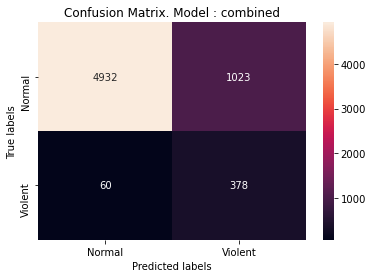

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title(f'Confusion Matrix. Model : {version}')
ax.xaxis.set_ticklabels(['Normal', 'Violent'])
ax.yaxis.set_ticklabels(['Normal', 'Violent'])

In [71]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print(f"Model version: {version}")
print("Accuracy: ", accuracy_score(test_y, predictions))
print("Precision: ", precision_score(test_y, predictions))
print("Recall: ", recall_score(test_y, predictions))

Model version: combined
Accuracy:  0.8305959643359925
Precision:  0.2698072805139186
Recall:  0.863013698630137


#### The combined approach is the one that maximizes the Recalll metric. Therefore, we will choose this model.
We will save the name of the training job so it can be accessed later in the deployment.

In [9]:
training_job_name = xgb_combined._current_job_name
print(type(training_job_name))

<class 'str'>


In [11]:
import json

with open("data/training_job_AWS.json", "w") as file:
    json.dump({"training_job":training_job_name},file)